In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Make all plots have inverse text/labels because I use dark theme.
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [2]:
def SieveOfEratosthenes(n):
    # Create a boolean array
    # "prime[0..n]" and initialize
    #  all entries it as true.
    # A value in prime[i] will
    # finally be false if i is
    # Not a prime, else true.
    result = []
    prime = [True for i in range(n+1)]
    p = 2
    while (p * p <= n):

        # If prime[p] is not
        # changed, then it is a prime
        if (prime[p] == True):

            # Update all multiples of p
            for i in range(p * p, n+1, p):
                prime[i] = False
        p += 1

    # Print all prime numbers
    for p in range(2, n+1):
        if prime[p]:
            result.append(p)
    return result

In [4]:
prime_table = SieveOfEratosthenes(821641) #prime 821641 makes exactly 65536 primes

In [24]:
#Cut prime table down to a perffered size at whatever increment to keep
chopped_prime_table = []
prime_keep = 500
spacing = 1
for i in range(0, prime_keep, spacing):
    chopped_prime_table = chopped_prime_table + prime_table[i:i+spacing]

In [6]:
len(chopped_prime_table)

500

In [22]:
#Test a range of bytes/chunks to read for factoring out.
best_byte_reduce = 0
best_read = {}
f = open('hoid.zip', 'rb')
for byte_read_size in range(2, 21):
    byte_position = 21
    found_reductions = 0
    byte_reduction = 1
    chunks = 20
    for i in range(byte_position,byte_position + chunks*byte_read_size,byte_read_size):
        f.seek(i, 0)
        data = f.read(byte_read_size)
        number = int.from_bytes(data, byteorder='little', signed=False)
        nums = []
        last = 1
        for x in chopped_prime_table:
            if number % x == 0 and number != 0:
                nums.append(x)
                last = x
        if number // last < 2**(8*(byte_read_size-byte_reduction)):
            found_reductions += 1
    total_byte_reduce = (found_reductions*byte_reduction/(chunks*byte_read_size))*100
    if total_byte_reduce > best_byte_reduce:
        best_byte_reduce = total_byte_reduce
        best_read = {'Chunks' : chunks, 'Read-Size': byte_read_size, 'Byte-Reduction': byte_reduction}
    print(f'\nWith reading {byte_read_size} bytes at a time over {chunks} chunk-size ({chunks*byte_read_size} bytes), found {found_reductions} instances to factor out {byte_reduction} bytes.\nThat is {total_byte_reduce}% byte reduction')
f.close()
print(f'\nFound {best_byte_reduce}% to be best with:\n{best_read}')


With reading 2 bytes at a time over 20 chunk-size (40 bytes), found 12 instances to factor out 1 bytes.
That is 30.0% byte reduction

With reading 3 bytes at a time over 20 chunk-size (60 bytes), found 5 instances to factor out 1 bytes.
That is 8.333333333333332% byte reduction

With reading 4 bytes at a time over 20 chunk-size (80 bytes), found 12 instances to factor out 1 bytes.
That is 15.0% byte reduction

With reading 5 bytes at a time over 20 chunk-size (100 bytes), found 9 instances to factor out 1 bytes.
That is 9.0% byte reduction

With reading 6 bytes at a time over 20 chunk-size (120 bytes), found 5 instances to factor out 1 bytes.
That is 4.166666666666666% byte reduction

With reading 7 bytes at a time over 20 chunk-size (140 bytes), found 8 instances to factor out 1 bytes.
That is 5.714285714285714% byte reduction

With reading 8 bytes at a time over 20 chunk-size (160 bytes), found 11 instances to factor out 1 bytes.
That is 6.875000000000001% byte reduction

With readi

In [25]:
#Take a specified chunk of bytes & read-size and then obtain an array of the Prime numbers where the
#read-size could be evenly divided into a new whole number that can be stored using 1 less byte.
#Also output an array of the indicies of these prime numbers within the Prime Table.

f = open('hoid.zip', 'rb')
chunks = 20
byte_position = 21
byte_read_size = 2
byte_reduction = 1
bytes_to_nums = []
for i in range(byte_position,byte_position + chunks*byte_read_size, byte_read_size):
    f.seek(i, 0)
    data = f.read(byte_read_size)
    number = int.from_bytes(data, byteorder='big', signed=False)
    bytes_to_nums.append(number)
f.close()

factored_byte_nums = np.empty((chunks))
factored_byte_nums[:] = np.nan
for i in range(chunks):
    if bytes_to_nums[i] == 0: #set any zero-bytes to have smallest table factor
        factored_byte_nums[i] = chopped_prime_table[0]
    else:
        for x in chopped_prime_table:
            if bytes_to_nums[i] % x == 0 and bytes_to_nums[i] // x < 2**(8*(byte_read_size-byte_reduction)):
                factored_byte_nums[i] = x
                break #break makes sure that the first working factor is used (bias towards smaller factors)

factored_indicies = np.empty((chunks))
factored_indicies[:] = np.nan
for ctr, each in enumerate(factored_byte_nums):
    if np.isnan(each) == False:
        factored_indicies[ctr] = chopped_prime_table.index(each)

In [26]:
factored_byte_nums

array([2.000e+00,       nan, 2.000e+00, 2.000e+00, 2.000e+00, 3.169e+03,
             nan, 1.310e+02, 7.390e+02, 1.787e+03,       nan, 5.930e+02,
       4.630e+02,       nan, 8.110e+02,       nan, 1.567e+03, 1.100e+01,
             nan, 1.300e+01])

In [27]:
factored_indicies

array([  0.,  nan,   0.,   0.,   0., 448.,  nan,  31., 130., 276.,  nan,
       107.,  89.,  nan, 140.,  nan, 246.,   4.,  nan,   5.])

In [28]:
#Take the total amount of prime indicies in the array and "wrap" it around onto itself to form a circle.
# then attempt to fit a spiral to the points
def spiral_fit(indicies_list, start: int, resolution: int, threshold, rate: int = 3):
    if rate < 3: rate = 3
    #Last element in scan_list is final resolution
    num_as = np.linspace(0.1,2,resolution)
    num_bs = np.linspace(0.1,1.9,resolution)
    num_ks = np.linspace(2,20,resolution)
    
    best_params_idx = (0,0,0)
    p = factored_indicies.copy()
    chunk_size = len(p)
    highest = np.nanmax(p)
    t = np.empty((chunks))
    t_best_max = 10000
    scan_list = [None]*3
    jump = 99999
    gap = jump
    first_go = True
    
    while jump > rate:
#         print(f'Previous Gap was: {gap}')
        jump = int(2*gap/rate)
        for ctr, idx in enumerate(best_params_idx):
            if first_go:
                gap = int(resolution/start)
                scan_list[ctr] = np.arange(start)*gap
                if resolution-1 not in scan_list[ctr]:
                    scan_list[ctr] = np.append(scan_list[ctr], resolution-1)
            elif jump <= rate:
                if idx + rate >= resolution: scan_list[ctr] = np.arange(idx - rate, resolution-1)
                else: scan_list[ctr] = np.arange(idx - rate, idx + rate)
            else:
                if idx + gap >= resolution:
                    scan_list[ctr] = np.arange(idx - gap, resolution-1)[::jump]
                    if resolution-1 not in scan_list[ctr]:
                        scan_list[ctr] = np.append(scan_list[ctr], resolution-1)
                elif idx - gap < 0:
                    scan_list[ctr] = np.arange(0, idx + gap)[::jump]
                    if idx + gap not in scan_list[ctr]:
                        scan_list[ctr] = np.append(scan_list[ctr], idx + gap)
                else:
                    scan_list[ctr] = np.arange(idx - gap, idx + gap)[::jump]
                    if idx + gap not in scan_list[ctr]:
                        scan_list[ctr] = np.append(scan_list[ctr], idx + gap)
        if first_go == False: gap = jump
        first_go = False
#         print(f'Jump is: {jump}')
#         print(f'A Scan list: {scan_list[0]}')
#         print(f'B Scan list: {scan_list[1]}')
#         print(f'K Scan list: {scan_list[2]}')
        for a_idx in list(scan_list[0]):
            a = num_as[a_idx]
            for b_idx in list(scan_list[1]):
                b = num_bs[b_idx]
                for k_idx in list(scan_list[2]):
                    k = num_ks[k_idx]
                    t[:] = np.nan
                    rotations = int(k/2)
                    radian_pos = np.linspace(0,2*np.pi, chunk_size) + b*np.pi
                    r_max = (k*np.pi)**a
                    points = r_max - (p/highest)*r_max #Not bothering to unit scale it here
                    for ctr, point in enumerate(points):
                        if np.isnan(point) == False and point != 0.0:
                            closest = 1000
                            #loop through all 2pi rotations from k
                            for rotation in range(rotations):
                                r_pos = ((rotation + 1)*radian_pos[ctr])**a# + np.abs(k*np.sin((rotation + 1)*radian_pos[ctr]))
                                #find the spiral location along an angle (times rotations)
                                #Subtract the real point by it and find its closest
                                dist = (abs(r_pos-point)/r_max)*(rotations*1.5)
                                if dist < closest:
                                    closest = dist
                            t[ctr] = closest
                    t_MAX = np.nanmax(t)
                    if t_MAX <= t_best_max: #for some reason needed to make variable or it only Trued once
                        best_params_idx = (a_idx, b_idx, k_idx)
                        t_best_max = t_MAX
#         print(f'We get: {best_params_idx}')
    return best_params_idx

In [29]:
#Same as the above, but see if I can reduce # of iterations with a fan-out method.
#This first does a coarse scan from min to max, then fans out from those points with higher resolution
#Went from 20min solve to 10sec with this change.
small_scan = 16
num_as = np.linspace(0.1,2,small_scan)
num_bs = np.linspace(0.1,1.9,small_scan)
num_ks = np.linspace(2,20,small_scan)
best_params = (0,0,0)
best_params_idx = (0,0,0)
p = r2.copy()
p = factored_indicies.copy()
chunk_size = len(p)
highest = np.nanmax(p)
t = np.empty((chunks))
t_best_max = 10000
for a_idx, a in enumerate(num_as):
    for b_idx, b in enumerate(num_bs):
        for k_idx, k in enumerate(num_ks):
            t[:] = np.nan
            rotations = int(k/2)
            radian_pos = np.linspace(0,2*np.pi, chunk_size) + b*np.pi
            r_max = (k*np.pi)**a
            points = r_max - (p/highest)*r_max
            for ctr, point in enumerate(points):
                if np.isnan(point) == False and point != 0.0:
                    closest = 1000
                    #loop through all 2pi rotations from k
                    #print(f'Point: {point}')
                    for rotation in range(rotations):
                        r_pos = ((rotation + 1)*radian_pos[ctr])**a
                        #print(f'r_pos #{rotation}: {r_pos}')
                        #find the spiral location along an angle (times rotations)
                        #Subtract the real point by it and find its closest
                        dist = (abs(r_pos-point)/r_max)#*(rotations*1.5)
                        if dist < closest:
                            closest = dist
                    t[ctr] = closest
            t_MAX = np.nanmax(t)
            #print(f'Max: {t_MAX}')
            if t_MAX < t_best_max: #for some reason needed to make variable or it only Trued once
                #print(f'True: {t_MAX}')
                best_params = (a, b, k)
                best_params_idx = (a_idx, b_idx, k_idx)
                t_best = t.copy()
                t_best_max = t_MAX
                #print(f'Params: {best_params_idx}')

print(best_params_idx)
print(f'Final best: {t_best_max}')

#Now fan outwards for efficiency
large_scan = 128
num_as = np.linspace(0.1,2,large_scan)
num_bs = np.linspace(0.1,1.9,large_scan)
num_ks = np.linspace(2,20,large_scan)
init_params_idx = [0,0,0]
fan_sizes = [int((3/small_scan)*large_scan)]*3 # if 1/x is % between indexes, then 3/x is a fan from n-1 to n+1
for i in range(3):
    #Basically turned into a percent but 1-index less on smaller. Then scaled up to new size + fan over it
    init_params_idx[i] = int(((best_params_idx[i]-1)/small_scan)*large_scan)
    print(f'{init_params_idx[i] + fan_sizes[i]}')
    if init_params_idx[i] < 1:#catch this condition so we don't get a negative number.
        init_params_idx[i] = 0
        fan_sizes[i] = int((2/small_scan)*large_scan) #can do 2/x for it
    if (init_params_idx[i] + fan_sizes[i]) > large_scan: #catch this conidtion so we don;t go larger than array
        fan_sizes[i] = (large_scan-1)-init_params_idx[i] #can do 1/x to reach the end

        
        
print(f'Initial param idx: {init_params_idx}')
print(f'Fan sizes: {fan_sizes}')
for a_idx in range(fan_sizes[0]):
    a = num_as[init_params_idx[0] + a_idx]
    for b_idx in range(fan_sizes[1]):
        b = num_bs[init_params_idx[1] + b_idx]
        for k_idx in range(fan_sizes[2]):
            k = num_ks[init_params_idx[2] + k_idx]
            t[:] = np.nan
            rotations = int(k/2)
            radian_pos = np.linspace(0,2*np.pi, chunk_size) + b*np.pi
            r_max = (k*np.pi)**a
            points = r_max - (p/highest)*r_max
#             print(f'r_max ({a},{b},{k}): {r_max}')
            for ctr, point in enumerate(points):
                if np.isnan(point) == False and point != 0.0:
                    closest = 1000
                    #loop through all 2pi rotations from k
                    for rotation in range(rotations):
                        r_pos = ((rotation + 1)*radian_pos[ctr])**a
                        #find the spiral location along an angle (times rotations)
                        #Subtract the real point by it and find its closest
                        dist = (abs(r_pos-point)/r_max)#*(rotations*1.5)
                        if dist < closest:
                            closest = dist
                    t[ctr] = closest
            t_MAX = np.nanmax(t)
#             print(f'OldMax: {t_best_max}   New: {t_MAX}')
            if t_MAX < t_best_max: #for some reason needed to make variable or it only Trued once
                print('True!')
                best_params = (a, b, k)
                best_params_idx = (init_params_idx[0] + a_idx, init_params_idx[1] + b_idx, init_params_idx[2] + k_idx)
                t_best = t.copy()
                t_best_max = t_MAX
print(best_params_idx)

(3, 15, 15)
Final best: 0.03968398949049129
40
136
136
Initial param idx: [16, 112, 112]
Fan sizes: [24, 15, 15]
(3, 15, 15)


In [17]:
t_best_max

0.03968398949049129

In [18]:
t_best

array([0.02432016,        nan, 0.0244499 , 0.00139052, 0.02110594,
              nan,        nan, 0.03141346, 0.03968399, 0.00838972,
              nan, 0.02860307, 0.00135915,        nan, 0.03363061,
              nan, 0.01275126, 0.02911783,        nan, 0.00091829])

In [19]:
best_params_idx

(3, 15, 15)

In [20]:
best_params

(0.48, 1.9, 20.0)

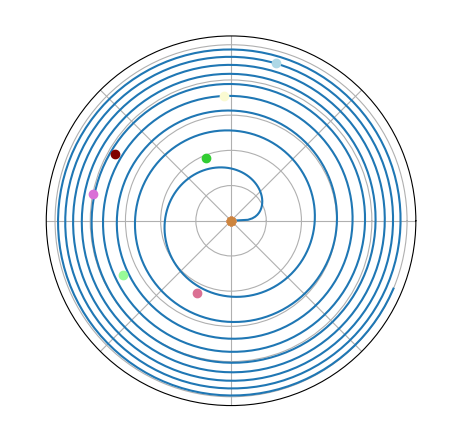

In [16]:
#Plot the fitted spiral to the array of indicies
p = factored_indicies.copy()
chunk_size = len(p)
highest = np.nanmax(p)
num_as = np.linspace(0.1,2,128)
num_bs = np.linspace(0,1.9,128)
num_ks = np.linspace(2,20,128)
a_i, b_i, k_i = (16, 112, 112)
a = num_as[a_i]
b = num_bs[b_i]
k = num_ks[k_i]
theta = np.linspace(0, k*np.pi, 1000)
r = theta**a# + np.abs(k*np.sin(theta))
r = r/np.max(r)
#theta3 = np.linspace(0, 2*np.pi, 1000)
#r3 = np.abs(np.cos(theta3*12.5 + 1.2*np.pi*12.5)) + np.abs(np.cos(theta3*3))
#r3 = r3/np.max(r3)
plt.polar(theta, r)
#plt.plot(theta3, r3)
r2 = np.max(r) - (p/highest)*np.max(r)
theta2 = np.linspace(0, 2*np.pi, chunk_size) + b*np.pi
colors = ['orange','green','purple','red','pink', 'olive', 'cyan','lightblue', 'lightgoldenrodyellow', 
 'limegreen', 'magenta', 'maroon', 'orchid', 'palegoldenrod','palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
 'peachpuff', 'peru', 'pink', 'plum', 'powderblue','sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'springgreen',
 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet','darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen',
 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange','darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue',
 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet']
for i in range(chunk_size):
    if r2[i] == max(r2):
        r2[i] = 0
    plt.plot(theta2[i], r2[i], 'o', color=colors[i])
plt.show()

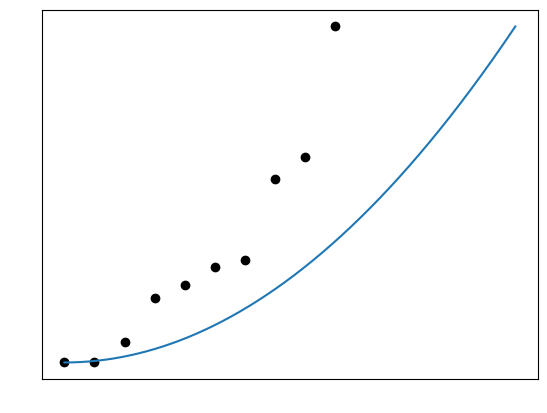

In [35]:
#Sort the indicies from lowest to highest then attempt to fit a curve to them
y = p
y.sort()
for i in range(len(y)):
    if y[i] != 0:
        y = y[i:]
        break
y = y/(max(y)-min(y))
x = np.linspace(0,1,len(y))
x2 = np.linspace(0,1,1000)
a2 = 2
y2 = x2**a2 + min(y)
plt.plot(x, y, 'o', color='black')
plt.plot(x2, y2)
plt.show()